In [1]:
from featureExtractor import *
subjects = [i for i in range (0, 27)]
exclude_subs = [5, 16, 19, 22, 24, 26]

subjects = [s for s in subjects if s not in exclude_subs]

In [2]:
lie_features = pd.read_csv("lie_features_clear_whole_35.csv", sep=',')
lie_features['descr_mean_pupil'] = (lie_features['descr_right_mean'] + lie_features['descr_left_mean'])/2
lie_features['react_mean_pupil'] = (lie_features['react_right_mean'] + lie_features['react_left_mean'])/2
lie_features['point_mean_pupil'] = (lie_features['point_right_mean'] + lie_features['point_left_mean'])/2
lie_feat_cols.append('descr_mean_pupil')
lie_feat_cols.append('react_mean_pupil')
lie_feat_cols.append('point_mean_pupil')

lie_features['premed_score_right'] = lie_features['react_right_mean'] / lie_features['descr_right_mean']
lie_features['premed_score_left'] = lie_features['react_left_mean'] / lie_features['descr_left_mean']
lie_feat_cols.append('premed_score_right')
lie_feat_cols.append('premed_score_left')
lie_features=lie_features.dropna()

In [3]:
quest_ans = preprocessQuest("data/personality_raw.csv")
quest_ans = quest_ans.loc[quest_ans['subject'].isin(subjects)]
quest_ans = quest_ans.sort_values(by=['subject'])
quest_ans = quest_ans.reset_index()
quest_ans['subject'] = quest_ans.index
quest_ans = quest_ans.drop('index', axis=1)

In [4]:
tnt_scores, sss = \
    coumpute_TnT_scores(lie_features, lie_feat_cols,
                        'right_mean', abs_ratio=False, norm_to_point=False)

In [5]:
goods = []

for sc in ["premed_index", 'descr_ratio', 'react_ratio']:
#for sc in ['react_ratio']:
    for q in quest_ans.columns:
        if(q == 'subject'): continue
        qa = quest_ans[[q]]
        intersect, slope, adj, p = linear_regression_quest_scores(tnt_scores, qa, score=sc)
        
        plot_qa = quest_ans[['subject', q]]
        #lie_plotQuestRegression(tnt_scores, sss,
        #                        plot_qa, slope[1], intersect, index_col=sc)
        
        if(p < 0.05):
            goods.append([q, sc, slope[1], adj, p, True])
        else:
            goods.append([q, sc, slope[1], adj, p, False])

reg_df = pd.DataFrame(columns=['quest_feat', 'feature', 'slope', 'asjust', 'p', 'is_relevant'], data=goods)    
reg_df.to_csv("V2_clear_35/reports/trait_regs.csv", sep='\t')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


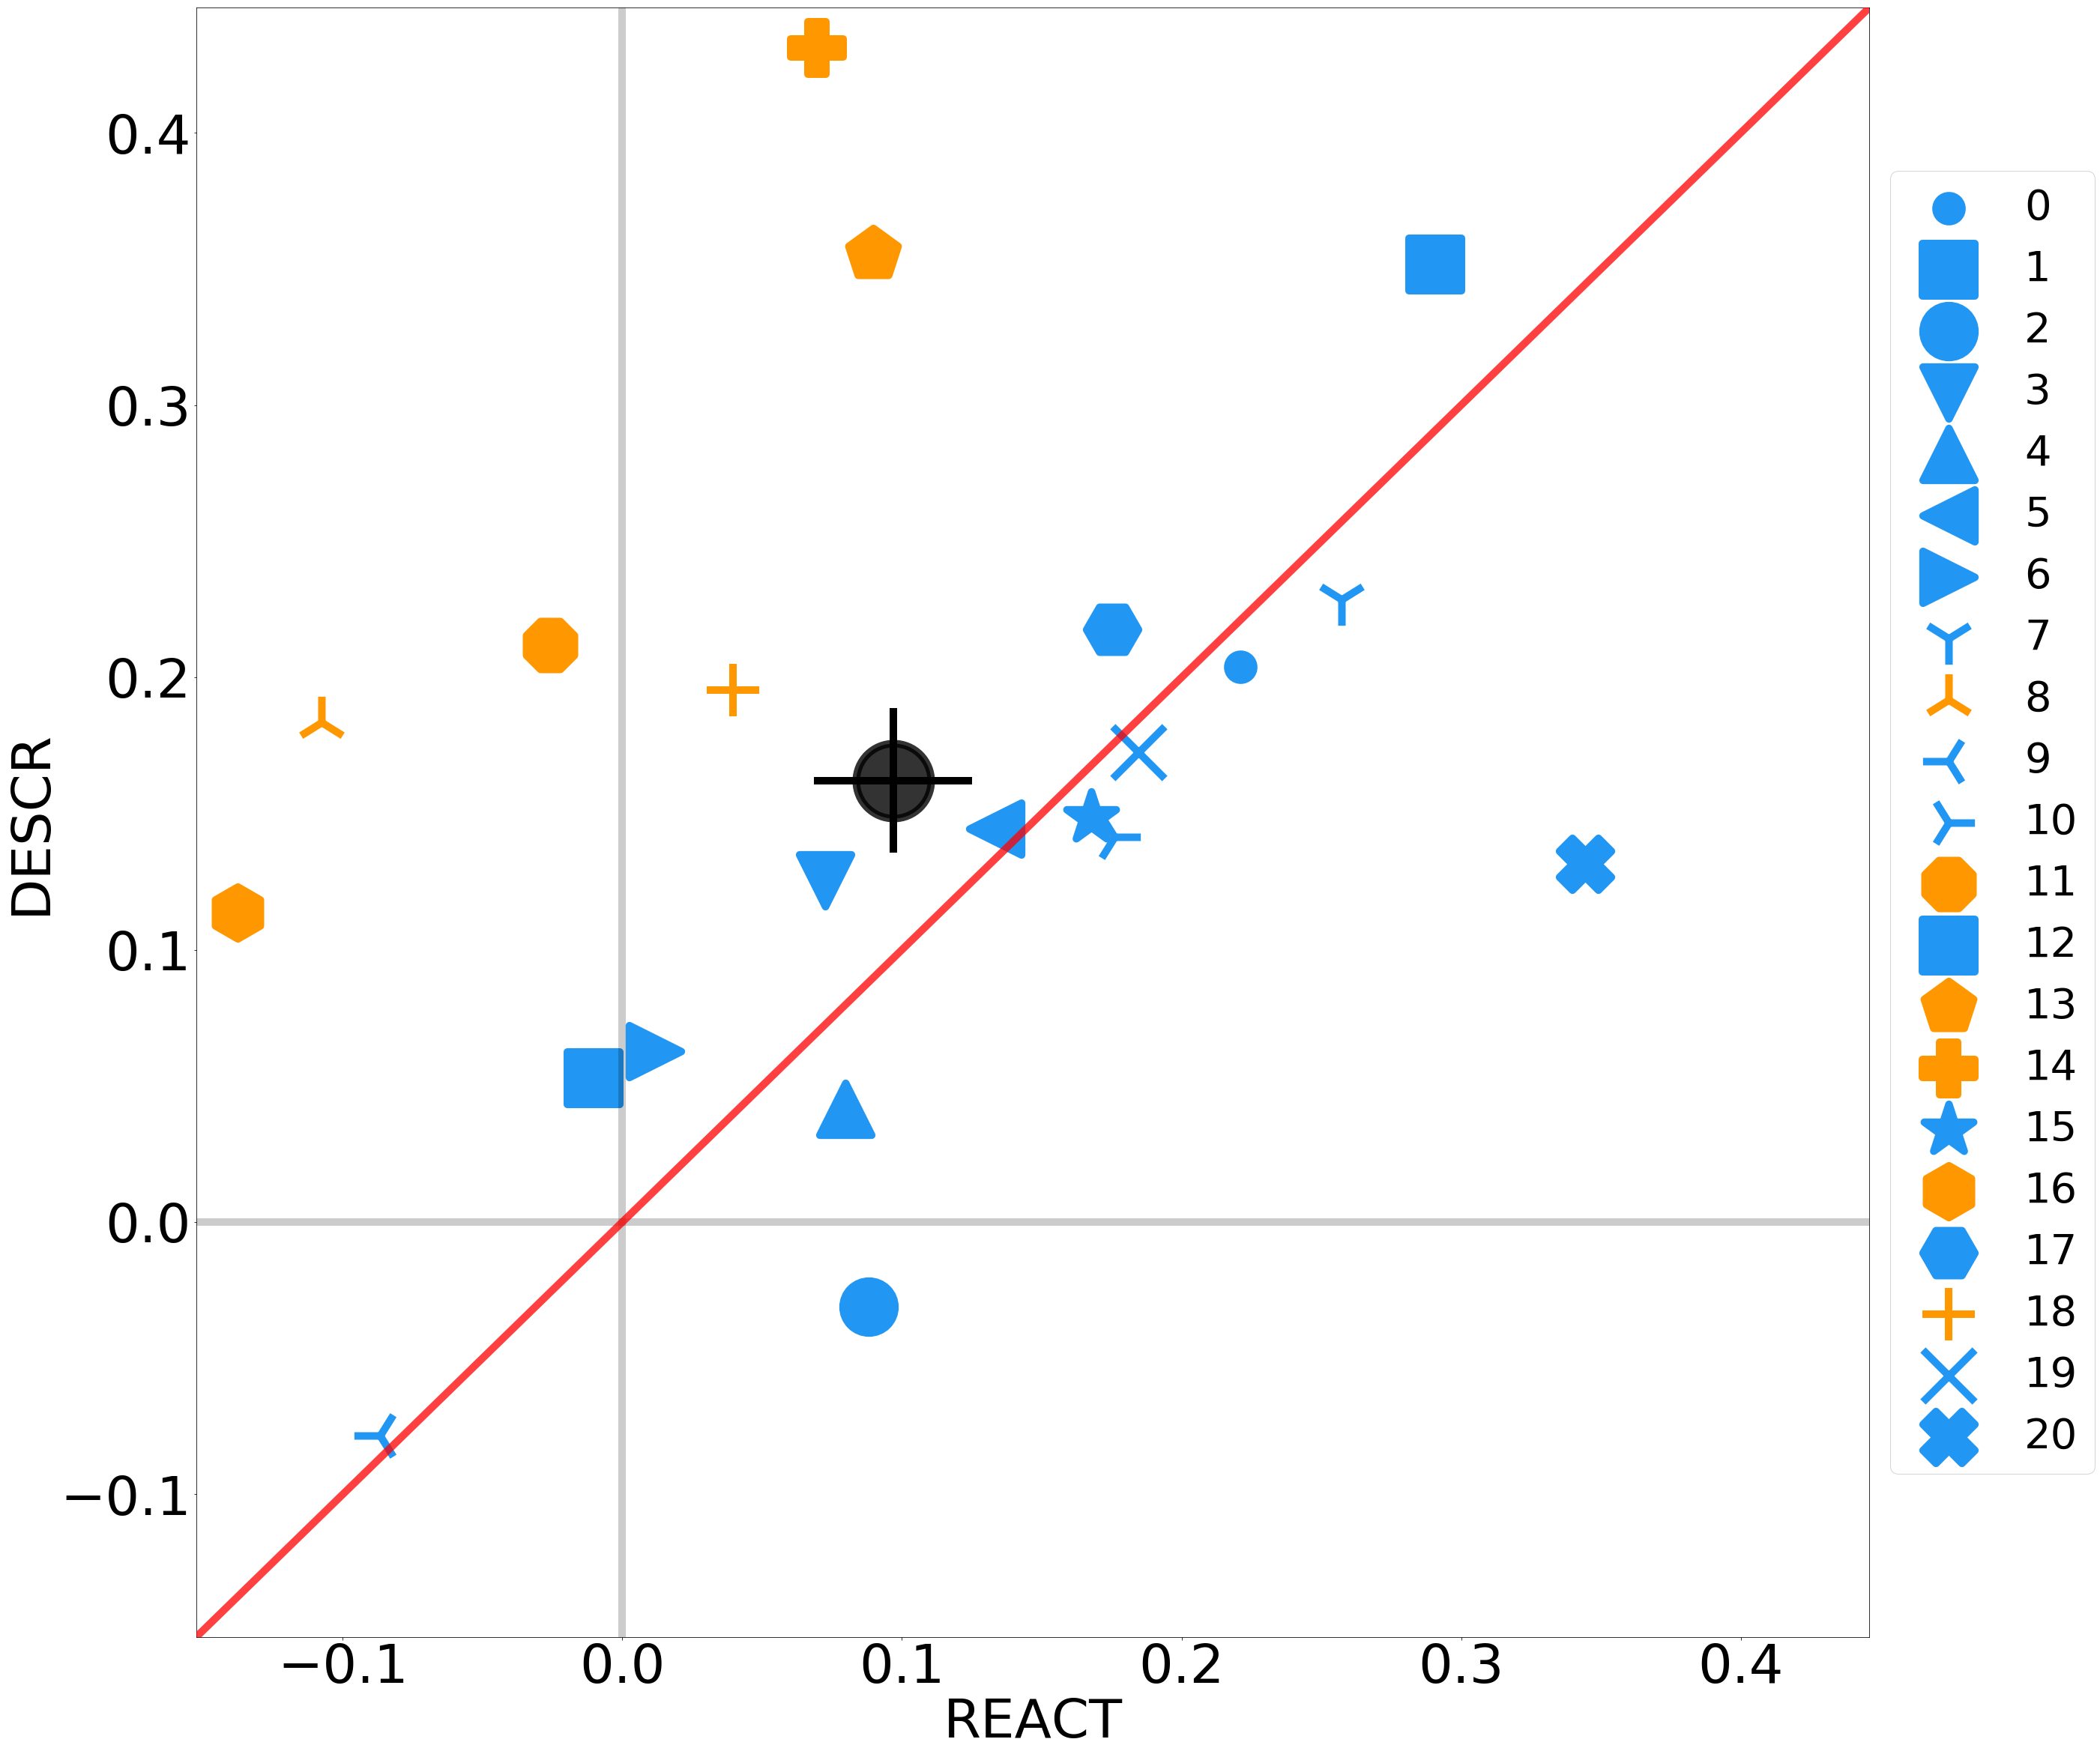

In [11]:

def TNT_points(feature, title, scale=4, abs_ratio=False, norm_to_point=False, save_root="", save=False):
    
    marker_map = {
    8 : ( "2", "#FF9800" ),
    11 : ( "8", "#FF9800" ),
    13 : ( "p", "#FF9800" ), 
    14 : ( "P", "#FF9800" ), 
    16 : ( "h", "#FF9800" ),
    18 : ( "+", "#FF9800" ),
    
    0 : ( ".", "#2196F3" ), 
    1 : ( ",", "#2196F3" ), 
    2 : ( "o", "#2196F3" ), 
    3 : ( "v", "#2196F3" ), 
    4 : ( "^", "#2196F3" ), 
    5 : ( "<", "#2196F3" ), 
    6 : ( ">", "#2196F3" ), 
    7 : ( "1", "#2196F3" ),     
    9 : ( "3", "#2196F3" ),
    10 : ( "4", "#2196F3" ),     
    12 : ( "s", "#2196F3" ),    
    15 : ( "*", "#2196F3" ),
    17 : ( "H", "#2196F3" ), 
    19 : ( "x", "#2196F3" ), 
    20 : ( "X", "#2196F3" ), 
    21 : ( "D", "#2196F3" ), 
    22 : ( "d", "#2196F3" ), 
    23 : ( "|", "#2196F3" ), 
    24 : ( "_", "#2196F3" ), 
    }
    
    tnt_scores, sss = coumpute_TnT_scores(lie_features, lie_feat_cols, feature, abs_ratio=abs_ratio, norm_to_point=norm_to_point)
    
    print(sss)
    
    f, axs = plt.subplots(1, figsize=(10 * scale, 10 * scale), num="{}".format(feature))
    pallX = tnt_scores['react_ratio'].mean(skipna=True)
    pallX_ste = tnt_scores['react_ratio'].sem(skipna=True)    
    pallY = tnt_scores['descr_ratio'].mean(skipna=True)
    pallY_ste = tnt_scores['descr_ratio'].sem(skipna=True)

    labels = []
    size = 1200 * scale
    label_font_size = 18 * scale
    legend_prop_size = {'size': 14 * scale}

    for i, sub in enumerate(sss):

        marker = marker_map[sub][0]

        axs.set_xlabel("REACT [mm]".format(title), fontsize=label_font_size)
        axs.set_ylabel("DESCR [mm]".format(title), fontsize=label_font_size)
        axs.set_label("{}".format(sub))
        
        color = marker_map[sub][1]
        labels.append("{}".format(sub))
        marker = marker_map[sub][0]
        
        axs.scatter(tnt_scores.loc[tnt_scores['subject'] == sub]['react_ratio'],
                            tnt_scores.loc[tnt_scores['subject'] == sub]['descr_ratio'],
                            s=size,
                            c=color,
                            marker=marker, linewidth=10)

    minX = tnt_scores['react_ratio'].min()
    maxX = tnt_scores['react_ratio'].max()        
    minY = tnt_scores['descr_ratio'].min()
    maxY = tnt_scores['descr_ratio'].max()       
    minXY = min(minX, minY)
    maxXY = max(maxX, maxY)

    mn = (maxXY + minXY) / 20

    minXY = minXY - mn
    maxXY = maxXY + mn
    
    lims = [minXY, maxXY]
    
    plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5), prop=legend_prop_size)  
    axs.scatter(pallX, pallY, s=2500*scale, alpha=0.8, color='black', linewidth=10)
    axs.errorbar(pallX, pallY,
                xerr=pallX_ste,
                yerr=pallY_ste, color='black', linewidth=10)
    
    axs.plot(lims, lims, alpha=0.75, zorder=100, linewidth=10, color='red')
    axs.axvline(color='black', alpha=0.2, linewidth=10)
    axs.axhline(color='black', alpha=0.2, linewidth=10)
    axs.tick_params(axis='both', which='major', labelsize=label_font_size)
    axs.set_xlim(minXY, maxXY)
    axs.set_ylim(minXY, maxXY)
    
    
    if(save):
        f.savefig(save_root.format(feature), dpi=100)
    

TNT_points('right_mean', "Right Mean", norm_to_point=False, abs_ratio=False, save=True, save_root="V2_clear_35/plot/hd/HD_tnt_{}.png")
